In [1]:
import numpy as np
import pandas as pd

from sklearn.naive_bayes import *
from sklearn.dummy import *
from sklearn.ensemble import *
from sklearn.neighbors import *
from sklearn.tree import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.calibration import *
from sklearn.linear_model import *
from sklearn.multiclass import *
from sklearn.svm import *
from sklearn.metrics import accuracy_score

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download("punkt")
nltk.download("stopwords")

import pickle

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\luuducthang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\luuducthang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
raw_data = pd.read_csv("./dataset/sms-message-spam-detector.csv", encoding="latin-1")

In [3]:
raw_data.head()

,class,message,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
raw_data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1, inplace=True)

In [5]:
raw_data["label"] = raw_data["class"].map({"ham": 0, "spam": 1})

In [6]:
raw_data.loc[:, "count"] = raw_data["message"].apply(lambda x: len(x))

In [7]:
raw_data.head()

,class,message,label,count
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


In [8]:
raw_data.describe(include="all")

,class,message,label,count
count,5572,5572,5572.000000,5572.000000
unique,2,5169,NaN,NaN
top,ham,"Sorry, I'll call later",NaN,NaN
freq,4825,30,NaN,NaN
mean,NaN,NaN,0.134063,80.118808
std,NaN,NaN,0.340751,59.690841
min,NaN,NaN,0.000000,2.000000
25%,NaN,NaN,0.000000,36.000000
50%,NaN,NaN,0.000000,61.000000
75%,NaN,NaN,0.000000,121.000000


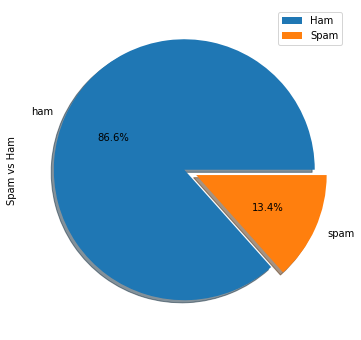

In [9]:
raw_data["class"].value_counts().plot(
    kind="pie", explode=[0, 0.1], figsize=(6, 6), autopct="%1.1f%%", shadow=True
)
plt.ylabel("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()

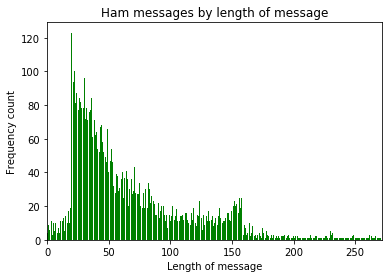

In [10]:
ham_count = pd.DataFrame(
    pd.value_counts(
        raw_data[raw_data["class"] == "ham"]["count"], sort=True
    ).sort_index()
)

# ploating data for ham messages
axes = plt.axes()
axes.set_xlim(0, len(ham_count))
plt.xlabel("Length of message")
plt.ylabel("Frequency count")
axes.set_title("Ham messages by length of message")
xline = np.linspace(0, len(ham_count) - 1, len(ham_count))
axes.bar(xline, ham_count["count"], color="g")
plt.show()

<BarContainer object of 122 artists>

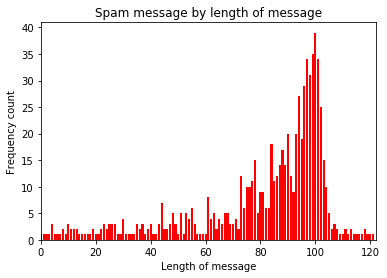

In [11]:
spam_count = pd.DataFrame(
    pd.value_counts(
        raw_data[raw_data["class"] == "spam"]["count"], sort=True
    ).sort_index()
)

# ploating data for spam messages
axes = plt.axes()
axes.set_xlim(0, len(spam_count))
plt.xlabel("Length of message")
plt.ylabel("Frequency count")
axes.set_title("Spam message by length of message")
xline_spam = np.linspace(0, len(spam_count) - 1, len(spam_count))
axes.bar(xline_spam, spam_count["count"], color="r")

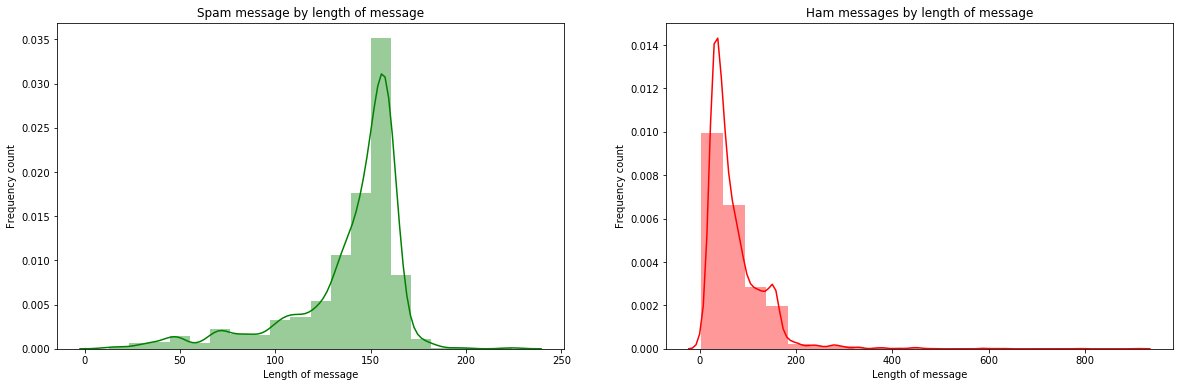

In [12]:
f, ax = plt.subplots(1, 2, figsize=(20, 6))

sns.distplot(
    raw_data[raw_data["class"] == "spam"]["count"], bins=20, ax=ax[0], color="g"
)
ax[0].set_title("Spam message by length of message")
ax[0].set_xlabel("Length of message")
ax[0].set_ylabel("Frequency count")

sns.distplot(
    raw_data[raw_data["class"] == "ham"]["count"], bins=20, ax=ax[1], color="r"
)
ax[1].set_title("Ham messages by length of message")
ax[1].set_xlabel("Length of message")
ax[1].set_ylabel("Frequency count")

plt.show()

In [13]:
top10 = (
    raw_data.groupby("message")["class"]
    .agg([len, np.max])
    .sort_values(by="len", ascending=False)
    .head(n=10)
)
print(top10)

                                                    len  amax
message                                                      
Sorry, I'll call later                               30   ham
I cant pick the phone right now. Pls send a mes...   12   ham
Ok...                                                10   ham
Your opinion about me? 1. Over 2. Jada 3. Kusru...    4   ham
Wen ur lovable bcums angry wid u, dnt take it s...    4   ham
Please call our customer service representative...    4  spam
Okie                                                  4   ham
Say this slowly.? GOD,I LOVE YOU &amp; I NEED Y...    4   ham
7 wonders in My WORLD 7th You 6th Ur style 5th ...    4   ham
Ok.                                                   4   ham


In [14]:
# Extract Feature With CountVectorizer
X = raw_data["message"]
y = raw_data["class"]

cv = CountVectorizer(stop_words="english")
X = cv.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=42
)
clf = MultinomialNB()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

# Save the model to disk
filename = "sms-message-spam-detector-naive-bayes.pkl"
pickle.dump(clf, open(filename, "wb"))

In [15]:
message = "Please call our customer service representative"
vect = cv.transform([message]).toarray()
my_prediction = clf.predict(vect)
print('Message: "{}". Predict: "{}"'.format(message, my_prediction[0]))

Message: "Please call our customer service representative". Predict: "spam"


In [16]:
# Extract Feature With TfidfVectorizer
X = raw_data["message"]
y = raw_data["class"]

tfidf = TfidfVectorizer(stop_words="english")

X = tfidf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=42
)

In [17]:
# function to train classifier
def train_classifier(clf, X_train, y_train):
    clf.fit(X_train, y_train)


# function to predict features
def predict_labels(clf, features):
    return clf.predict(features)

In [18]:
# Initialize the models

clf_model = [
    BernoulliNB(alpha=1.0, fit_prior=True),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(
        n_estimators=10, max_depth=None, min_samples_split=2, random_state=0
    ),
    AdaBoostClassifier(n_estimators=100),
    BaggingClassifier(),
    ExtraTreesClassifier(),
    GradientBoostingClassifier(),
    DecisionTreeClassifier(),
    CalibratedClassifierCV(),
    DummyClassifier(),
    PassiveAggressiveClassifier(),
    RidgeClassifier(),
    RidgeClassifierCV(),
    SGDClassifier(),
    OneVsRestClassifier(SVC(kernel="linear")),
    OneVsRestClassifier(LogisticRegression()),
    KNeighborsClassifier(n_neighbors=3),
]

In [19]:
import re

pred_val = []

for clf_mod in range(len(clf_model)):
    train_classifier(clf_model[clf_mod], X_train, y_train)
    y_pred = predict_labels(clf_model[clf_mod], X_test)
    pred_val.append(accuracy_score(y_test, y_pred))
    print(
        "Model: {}. Prediction Score: {}".format(
            re.search(r"(.+)\(", str(clf_model[clf_mod])).group(1), pred_val[clf_mod]
        )
    )

Model: BernoulliNB. Prediction Score: 0.9707842132239877
Model: DecisionTreeClassifier. Prediction Score: 0.9707842132239877
Model: RandomForestClassifier. Prediction Score: 0.9677088672475653
Model: AdaBoostClassifier. Prediction Score: 0.97385955920041
Model: BaggingClassifier. Prediction Score: 0.973347001537673


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Model: ExtraTreesClassifier. Prediction Score: 0.97385955920041
Model: GradientBoostingClassifier. Prediction Score: 0.9589953869810354
Model: DecisionTreeClassifier. Prediction Score: 0.9697590978985136


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Model: CalibratedClassifierCV. Prediction Score: 0.9794976934905176
Model: DummyClassifier. Prediction Score: 0.7811378780112763
Model: PassiveAggressiveClassifier. Prediction Score: 0.9779600205023065
Model: RidgeClassifier. Prediction Score: 0.97385955920041
Model: RidgeClassifierCV(alphas=array. Prediction Score: 0.9789851358277806
Model: SGDClassifier. Prediction Score: 0.9794976934905176
Model: OneVsRestClassifier(estimator=SVC. Prediction Score: 0.9764223475140953
Model: OneVsRestClassifier(estimator=LogisticRegression. Prediction Score: 0.9425935417734496


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Model: KNeighborsClassifier. Prediction Score: 0.9103024090210149


In [20]:
spam_messages = raw_data[raw_data["class"] == "spam"]["message"]
ham_messages = raw_data[raw_data["class"] == "ham"]["message"]


def extract_words(messages):
    extracter = []
    words = [
        word.lower()
        for word in word_tokenize(str(messages))
        if word.lower() not in stopwords.words("english") and word.lower().isalpha()
    ]
    extracter = extracter + words
    return extracter


spam_words = extract_words(spam_messages)
ham_words = extract_words(ham_messages)

In [21]:
def wordcloud(words):
    wordcloud_list = WordCloud(width=600, height=400).generate(" ".join(words))
    plt.figure(figsize=(10, 8), facecolor="k")
    plt.imshow(wordcloud_list)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

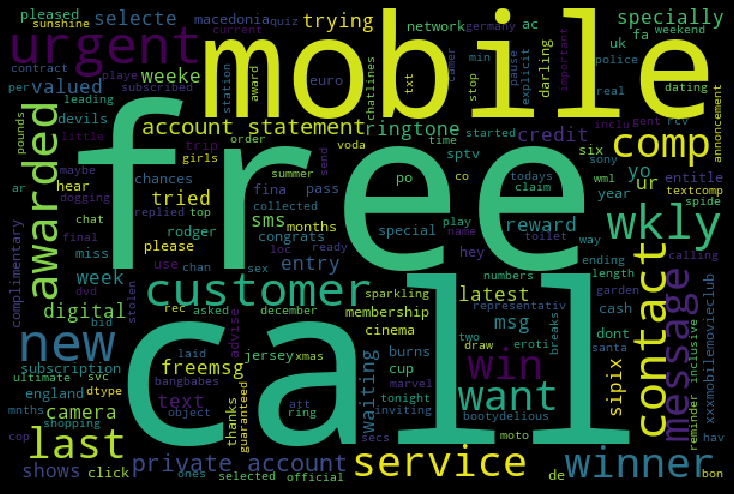

In [22]:
wordcloud(spam_words)

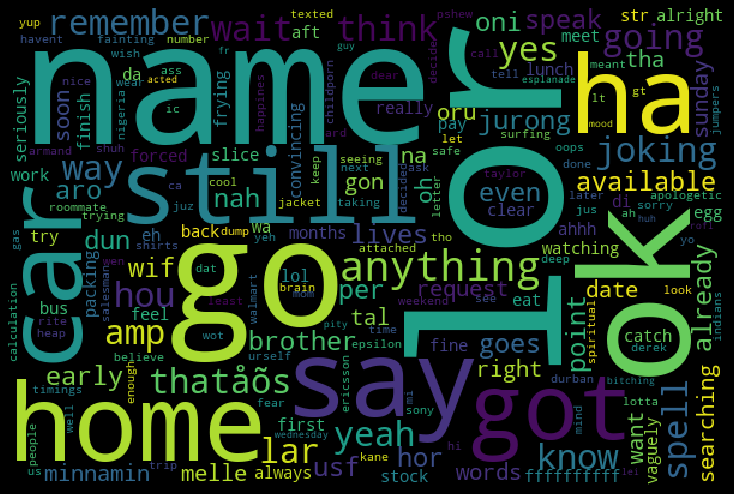

In [23]:
wordcloud(ham_words)